In [1]:
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def rectangle_gal_to_icrs(l_bounds, b_bounds):
    '''
    Converts a rectangular region in Galactic coordinates to RA/Dec bounds in ICRS.

    Parameters
    ----------
    l_bounds : list of float
        [min_longitude, max_longitude] in degrees.
    b_bounds : list of float
        [min_latitude, max_latitude] in degrees.

    Returns
    -------
    ra_bounds : list of float
        [min_RA, max_RA] in degrees.
    dec_bounds : list of float
        [min_Dec, max_Dec] in degrees.
    '''
    corners = [
        (l_bounds[0], b_bounds[0]), # bottom left
        (l_bounds[0], b_bounds[1]), # top left
        (l_bounds[1], b_bounds[1]), # top right
        (l_bounds[1], b_bounds[0])]  # bottom right
    
    
    coords=SkyCoord(l=[c[0]*u.deg for c in corners], # define each skycoord l value based on previous definition
                    b=[c[1]*u.deg for c in corners], 
                    frame='galactic').transform_to('icrs') # define coords as pre-transformed to ICRS
    #print(coords)

    # Define new 'rectangle' based on the bounds in RA/Dec
    ra_bounds = [np.min(coords.ra.deg), np.max(coords.ra.deg)] 
    dec_bounds = [np.min(coords.dec.deg), np.max(coords.dec.deg)]
    return ra_bounds, dec_bounds

# Epanechnikov kernel
def k_E(u):
    k = 0.75*(1.-u**2)
    k[k<0] = 0
    return k


def kde(Xdata, Xgrid, h=None, hmin=None, norm=True, kernel=k_E):
    
    # find optimum bandwidth
    if h is None:
        IQR = np.percentile(Xdata,75) - np.percentile(Xdata,25)
        hh = min(np.std(Xdata),IQR/1.34) * 0.9/len(Xdata)**0.2
    else:
        hh = np.copy(h)
    
    # enforce minimum bandwidth
    if hmin is not None:
        if np.ndim(hh) > 0:
            print('kde: increased width to %g for %d of %d data' % (hmin,sum(hh < hmin),len(hh)))
            hh[hh < hmin] = hmin
        else:
            if hh < hmin:
                print('kde: width h_opt = %g increased to %g' % (hh,hmin))
                hh = hmin
        
    k = np.array([ np.sum( kernel((x-Xdata)/hh) / hh ) for x in Xgrid ])
    
    if norm:
        k = k/len(Xdata)

    return k

In [3]:
# # Define total region
# l_range = [210, 232] # galactic longitude: approximately anticenter 
# b_range = [-10, 12] # galactic latitude: centered on the disk
 
# # Define tiling step size (degrees)
# l_step = 4
# b_step = 3

# # Quantity limits
# mag_lim = 18
# parallax_lim = 0.8 #  d < 1250 pc

# # Initialize list to collect tile results
# all_results = []

# # Tile the full region and query each individually
# for l_start in range(l_range[0], l_range[1], l_step): # (210, 214, 218, ...)
#     for b_start in range(b_range[0], b_range[1], b_step): # (-10, -7, -4, ...)
#         # Define tile
#         l_bounds = [l_start, l_start + l_step]
#         b_bounds = [b_start, b_start + b_step]
#         # Convert tile to ICRS coords
#         ra_bounds, dec_bounds = rectangle_gal_to_icrs(l_bounds, b_bounds)
#         print(ra_bounds, dec_bounds)
#         # Query for tile region
#         query = f"""
#         SELECT TOP 100000
#           source_id, ra, dec, parallax, parallax_error,
#           pmra, pmra_error, pmdec, pmdec_error,
#           phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, radial_velocity
#         FROM gaiadr3.gaia_source
#         WHERE
#           ra BETWEEN {ra_bounds[0]} AND {ra_bounds[1]}
#           AND dec BETWEEN {dec_bounds[0]} AND {dec_bounds[1]}
#           AND phot_g_mean_mag < {mag_lim}
#           AND parallax > {parallax_lim}
#           AND parallax IS NOT NULL
#           AND pmra IS NOT NULL
#           AND pmdec IS NOT NULL
#           AND radial_velocity IS NOT NULL
#         """
#         print(f"Querying tile: l={l_bounds}, b={b_bounds} ...") # print status updates
#         # Launch query to Gaia
#         job = Gaia.launch_job_async(query)
#         result = job.get_results().to_pandas()
#         all_results.append(result) # collect results from each tile in all_results list
#         print('\ntile complete\n') # print when moving to next iteration

# print('\n ------QUERYING COMPLETE------ \n')

In [4]:
# # Combine results
# field_df = pd.concat(all_results, ignore_index=True)
# print(f"Total stars retrieved: {len(field_df)}")

In [5]:
# # Organize & view results
# field_df.drop_duplicates(subset="SOURCE_ID", inplace=True) # Only have one of each source
# field_df = field_df.rename(columns={'phot_g_mean_mag': 'g', 'phot_bp_mean_mag': 'bp', 'phot_rp_mean_mag': 'rp', 'radial_velocity': 'radvel'})
# #filename = 'field_full.csv'
# filename_smaller = 'field_reduced.csv'
# field_df.to_csv(filename_smaller, index=False) # write file to save locally


In [6]:
field_df1 = pd.read_csv('field_reduced.csv')
field_df1

,SOURCE_ID,ra,dec,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,g,bp,rp,radvel
0,3021902881679086720,92.628436,-2.683011,1.636544,0.017716,14.190818,0.015782,-18.769558,0.015889,13.178302,13.572328,12.605893,90.288925
1,3121124357157504384,92.628520,-1.471477,0.970248,0.032041,1.880075,0.034676,6.600355,0.029784,14.911346,15.502526,14.162456,39.882140
2,3021684555604185472,92.628543,-3.557397,2.093317,0.020265,2.600883,0.025756,-12.600301,0.022597,14.391770,14.986608,13.651387,36.017360
3,3021476030648623232,92.628668,-3.970094,1.339326,0.021877,-0.171980,0.020877,-7.916022,0.020050,14.329100,14.699373,13.784427,-18.122404
4,3021860889780298624,92.628909,-2.920627,2.338501,0.016798,17.889005,0.018173,15.418319,0.016696,11.696573,11.993664,11.230495,19.861431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
376298,3063012247050711296,125.124567,-8.289227,2.103889,0.020082,-28.507362,0.023718,8.538227,0.017632,12.906841,13.241775,12.409788,10.192587
376299,3063012247050771840,125.129609,-8.292680,0.892833,0.020203,-1.672284,0.028495,1.070941,0.018942,13.843898,14.101920,13.431932,12.978785
376300,3063013277842841216,125.223818,-8.259188,1.258155,0.025027,-3.926824,0.030125,-4.131983,0.022428,11.505006,11.786243,11.062000,37.466064
376301,3063014308634994816,125.189828,-8.232549,0.872659,0.024387,-6.001680,0.028192,-8.424526,0.022219,14.665952,15.033874,14.128641,50.347843


42695 42695


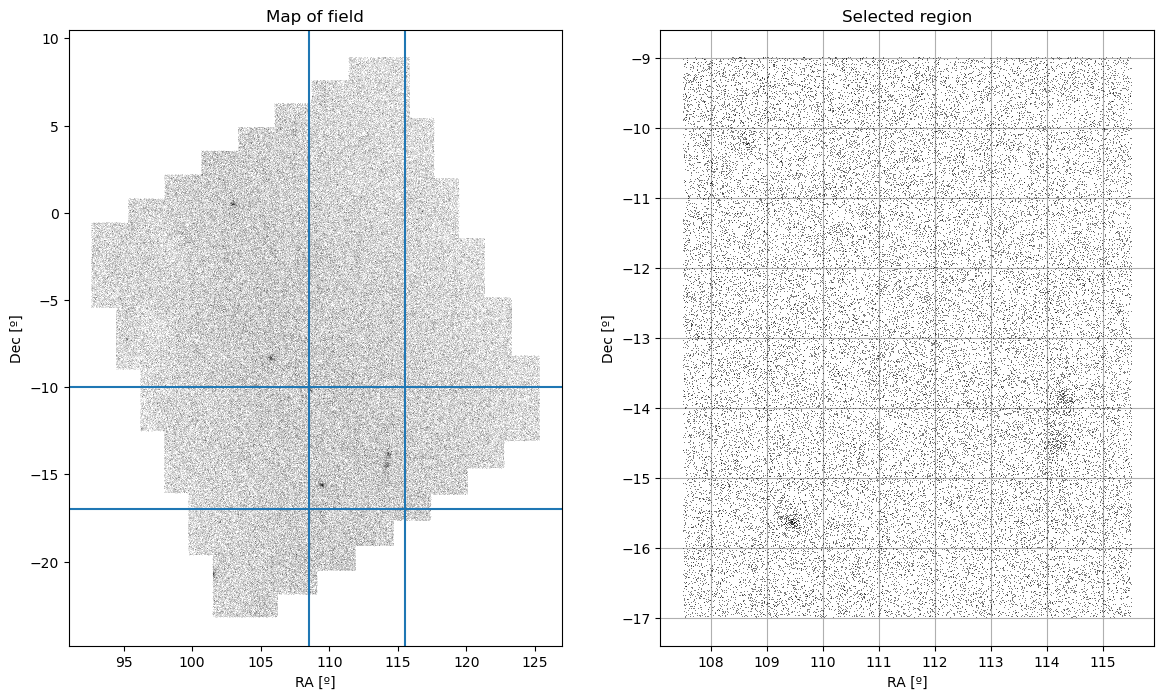

In [30]:
plt.figure(figsize=(14, 8))
plt.subplot(1,2,1)
plt.plot(field_df1.ra, field_df1.dec, 'k,', alpha=0.08)

plt.xlabel('RA [º]'); plt.ylabel('Dec [º]'); plt.title('Map of field')
#plt.grid(True)

plt.axvline(108.5); plt.axvline(115.5)
plt.axhline(-17); plt.axhline(-10)

###### DEFINE FIELD DATAFRAMES ######
field_df = field_df1.loc[(field_df1.ra > 107.5) & (field_df1.ra < 115.5) & (field_df1.dec > -17) & (field_df1.dec < -9)]
field_df2 = field_df1.loc[(field_df1.ra > 107.5) & (field_df1.ra < 115.5) & (field_df1.dec > -17) & (field_df1.dec < -9)]
#####################################
print(len(field_df), len(field_df2))

plt.subplot(1,2,2)
plt.plot(field_df.ra, field_df.dec, 'k,', alpha=0.5)

plt.xlabel('RA [º]'); plt.ylabel('Dec [º]'); plt.title('Selected region')
plt.grid(True)

In [8]:

#print(field_df['ra'].describe(),field_df['dec'].describe(),field_df['parallax'].describe(), 
 #     field_df['pmra'].describe(), field_df['pmdec'].describe(), field_df['radvel'].describe())

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import time

### Clustering by RA/Dec, parallax

#### Parameter tuning

In [33]:
# Build the feature matrix --- shape (n_samples, n_features)
X = np.vstack([field_df.ra,field_df.dec, field_df.parallax]).T

# Scale features
Xs = StandardScaler().fit_transform(X)

# Parameter ranges
eps_values = np.linspace(0.02, 0.07, 15)
min_samples_values = [5, 10, 15, 20, 25]

# Track best configuration
best_score_init = -1
best_params = None # initialize best_params
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # calculate DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(Xs)
        labels = db.labels_

        # count (real) clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Only evaluate silhouette if 2 or more clusters exist
        if n_clusters >= 2:
            score = silhouette_score(Xs, labels)
            results.append((eps, min_samples, score))
            print(f"eps={eps:.4f}, min_samples={min_samples} : silhouette={score:.4f}")

            if score > best_score_init:
                best_score_init = score # reassign best score to current score if better than previous
                best_params = (eps, min_samples)

best_score = best_score_init
print("\nBest parameters:")
print(f"eps={best_params[0]:.4f}, min_samples={best_params[1]} → silhouette={best_score:.4f}")

eps=0.0200, min_samples=5 : silhouette=-0.5257
eps=0.0236, min_samples=5 : silhouette=-0.5860
eps=0.0236, min_samples=10 : silhouette=-0.4631
eps=0.0271, min_samples=5 : silhouette=-0.7080
eps=0.0271, min_samples=10 : silhouette=-0.4805
eps=0.0271, min_samples=15 : silhouette=-0.4585
eps=0.0307, min_samples=5 : silhouette=-0.7378
eps=0.0307, min_samples=10 : silhouette=-0.4711
eps=0.0307, min_samples=15 : silhouette=-0.4801
eps=0.0307, min_samples=20 : silhouette=-0.3226
eps=0.0343, min_samples=5 : silhouette=-0.7307
eps=0.0343, min_samples=10 : silhouette=-0.4811
eps=0.0343, min_samples=15 : silhouette=-0.4711
eps=0.0343, min_samples=20 : silhouette=-0.4554
eps=0.0343, min_samples=25 : silhouette=-0.3211
eps=0.0379, min_samples=5 : silhouette=-0.6869
eps=0.0379, min_samples=10 : silhouette=-0.4953
eps=0.0379, min_samples=15 : silhouette=-0.4671
eps=0.0379, min_samples=20 : silhouette=-0.4715
eps=0.0379, min_samples=25 : silhouette=-0.3176
eps=0.0414, min_samples=5 : silhouette=-0.6177

(0.03785714285714286, 25)


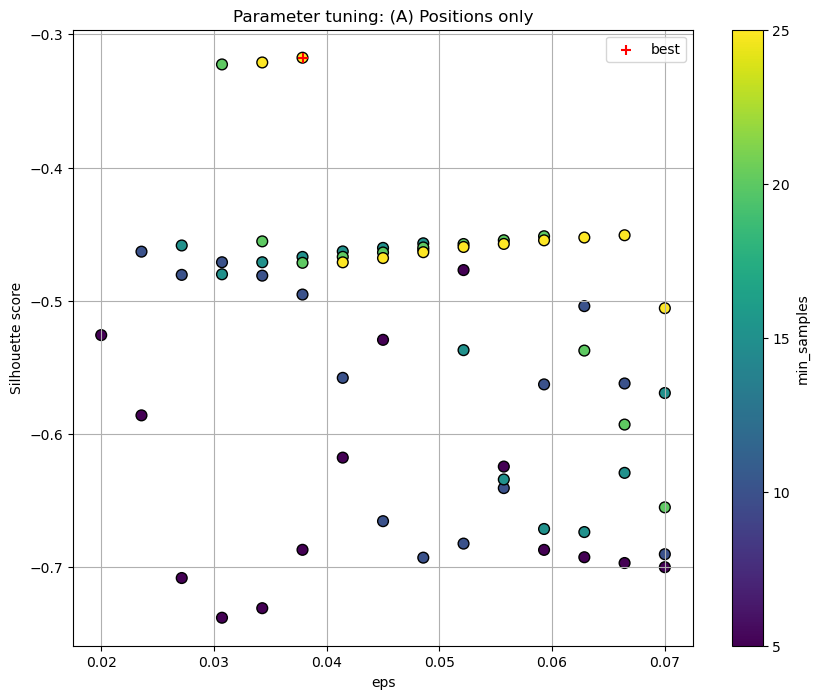

In [34]:
# Visualize tuning results
tuning_res = pd.DataFrame(results,columns=["eps", "min_samples", "silhouette"])

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    tuning_res.eps,
    tuning_res.silhouette,
    c=tuning_res.min_samples,
    cmap='viridis',
    s=60,
    edgecolor='k'
)

plt.scatter(best_params[0],best_score, c='r', marker='+', s=60, label='best')
cbar = plt.colorbar(scatter)
ticks_to_show = np.sort(np.unique(tuning_res.min_samples))
cbar.set_ticks(ticks_to_show)
cbar.set_ticklabels([str(v) for v in ticks_to_show])
cbar.set_label('min_samples')
plt.grid(True)

plt.title('Parameter tuning: (A) Positions only'); plt.legend(); plt.xlabel('eps'); plt.ylabel('Silhouette score')

print(best_params)

In [35]:
# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.hist(X[:,0], density=True)
# plt.xlabel('RA[º]'); plt.ylabel('density'); plt.title('RA dist.')
# plt.subplot(1,2,2)
# plt.hist(Xs[:,0], density=True)
# plt.xlabel('RA[º]'); plt.title('Scaled RA dist.')
# plt.show()

# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.hist(X[:,1], density=True)
# plt.xlabel('Dec[º]'); plt.ylabel('density'); plt.title('Dec dist.')
# plt.subplot(1,2,2)
# plt.hist(Xs[:,1], density=True)
# plt.xlabel('Dec[º]'); plt.title('Scaled Dec dist.')
# plt.show()

# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.hist(X[:,2], bins=50, density=True)
# plt.xlabel('parallax [mas]'); plt.ylabel('density'); plt.title('Parallax dist.')
# plt.subplot(1,2,2)
# plt.hist(Xs[:,2], bins=50, density=True)
# plt.xlabel('parallax [mas]'); plt.title('Scaled parallax dist.'); plt.xlim(-1,10)
# plt.show()

### DBSCAN

Estimated number of clusters: 4
Estimated number of noise points: 42249
Total number of points: 42695


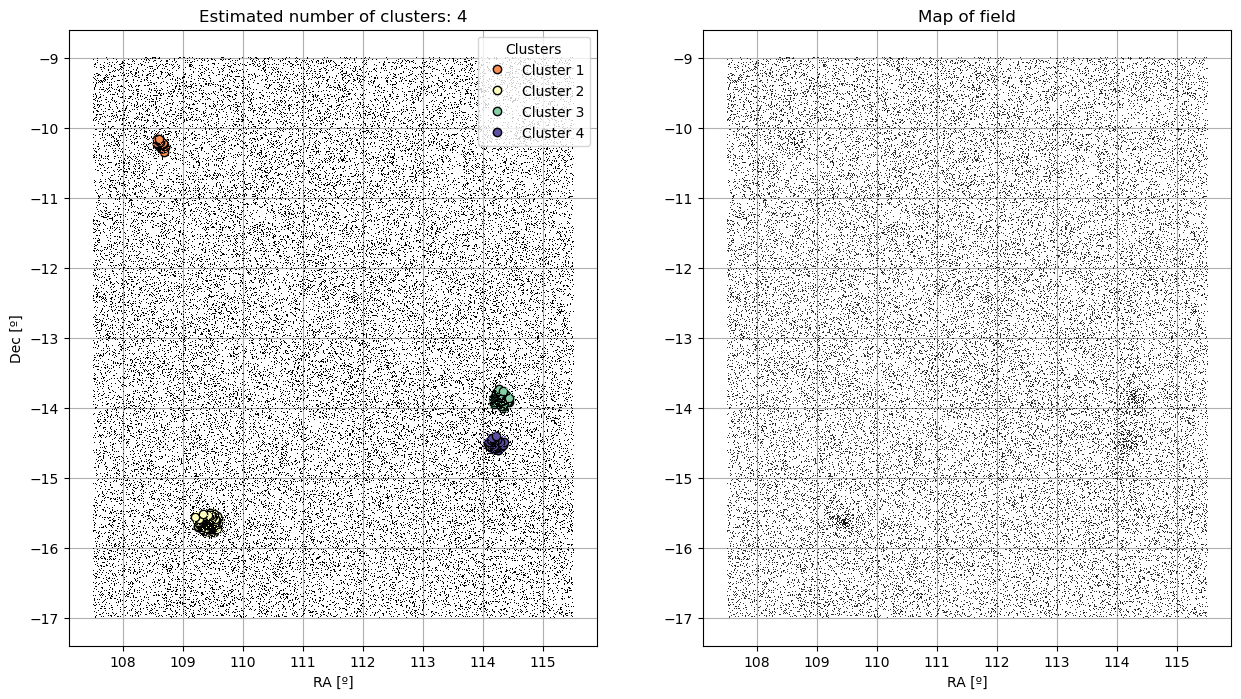

In [89]:
# benchmarking values eps=0.0379, min_samples=25

# Build the feature matrix --- shape (n_samples, n_features)

X = np.vstack([field_df.ra,field_df.dec, field_df.parallax]).T


# Scale features
# Xs = RobustScaler().fit_transform(X)
Xs = StandardScaler().fit_transform(X)

# Dimensionality reduction
#X_pca = PCA(n_components=2).fit_transform(Xs)
#start = time.time()

# Compute DBSCAN
e = 0.0379; m = 14
#################################################
#################################################
db = DBSCAN(eps=e, min_samples=m).fit(Xs) # based on choices above
#db = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit(Xs) # based on silhouette hyperparameter optimization (BENCHMARK)
#################################################
#################################################

#print("Done in", time.time() - start, "seconds")
labels = db.labels_

# Bool mask that is True for values that belong to a cluster (i.e. not outliers)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Total number of points: %d' % len(Xs))
#print(f"Silhouette score: {silhouette_score(Xs, labels):.4f}")

# Choose the number of colors based on the number of clusters (i.e., the number of unique cluster labels)
# Black is removed and is used for noise instead.
unique_labels = np.unique(labels)
colors = [plt.cm.Spectral(i) for i in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(15,8))
# Now plot each cluster, one by one
plt.subplot(1,2,1)

######  used chatgpt to make this legend ######
handles = []  # to store legend handles
labels_plot = []  # to store corresponding cluster numbers

for k, col in zip(unique_labels, colors):
    if k == -1:
        # sets the color for the -1 label to black
        # this is just the way the matplotlib colormap values are set up
        col = [0, 0, 0, 1]
        cluster_label = 'Noise'
    else:
        cluster_label = f"Cluster {k+1}"

    class_member_mask = (labels == k) # bool mask, True where the label is equal to k

    xy = X[class_member_mask & core_samples_mask]
    h1 = plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6, label=cluster_label)

    # Plot the outliers as a black 'x'
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], ',', markerfacecolor=tuple(col),markeredgecolor='k', markersize=0.5)
    plt.xlabel('RA [º]'); plt.ylabel('Dec [º]')

    if k != -1:
        handles.append(h1[0])
        labels_plot.append(cluster_label)

plt.grid(True)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.legend(handles=handles, labels=labels_plot, title="Clusters",  loc='upper right')


plt.subplot(1,2,2)
plt.plot(field_df.ra, field_df.dec, 'k,', alpha=0.8)
plt.xlabel('RA [º]'); plt.title('Map of field')
plt.grid(True)
plt.show()

#score = silhouette_score(Xs, labels)
#print(f"silhouette={score:.4f}")

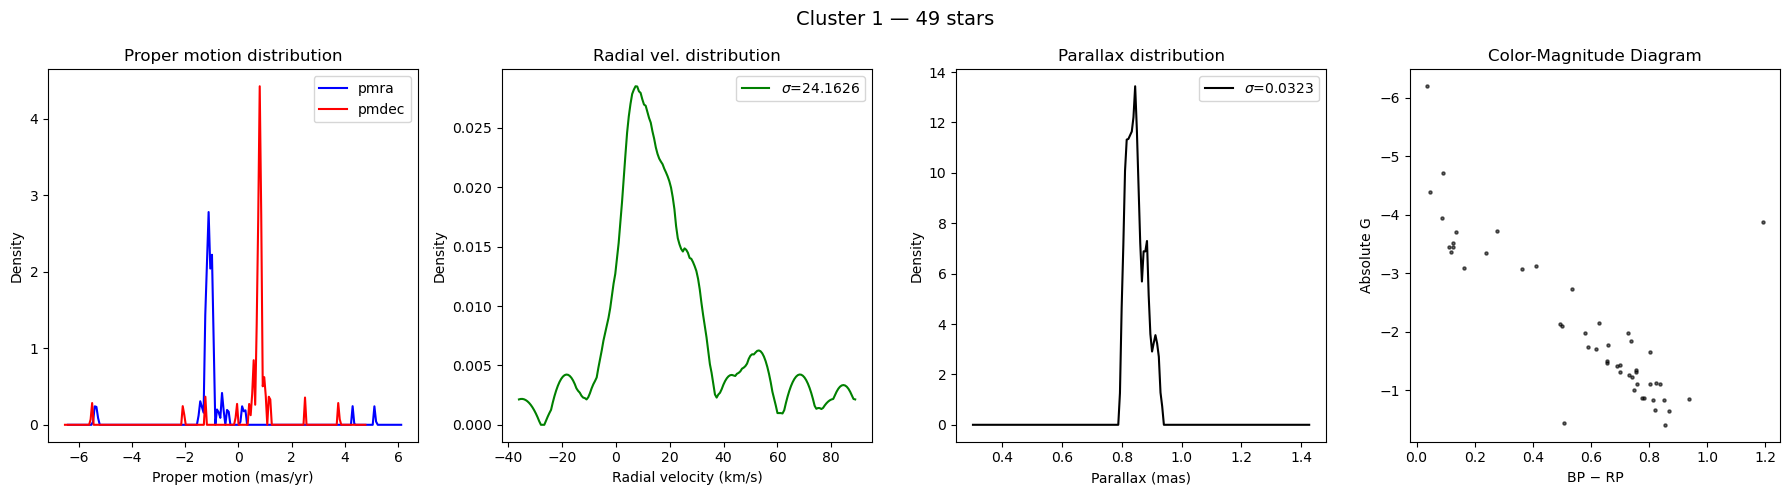

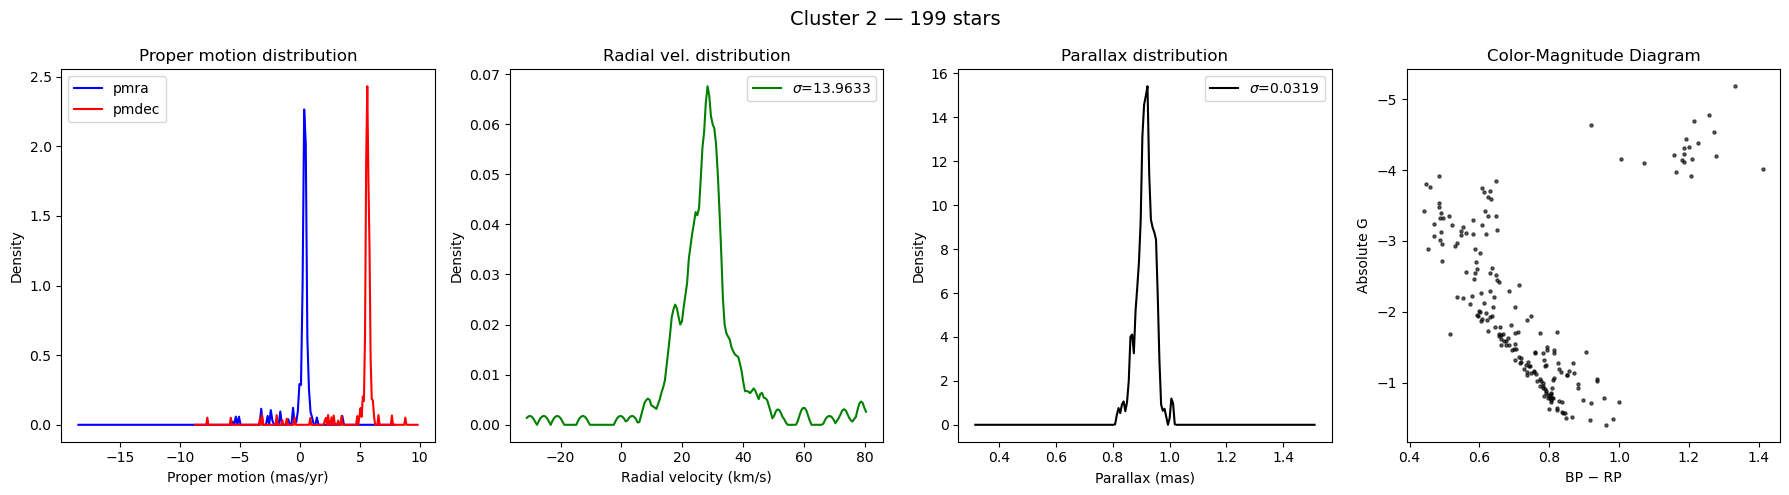

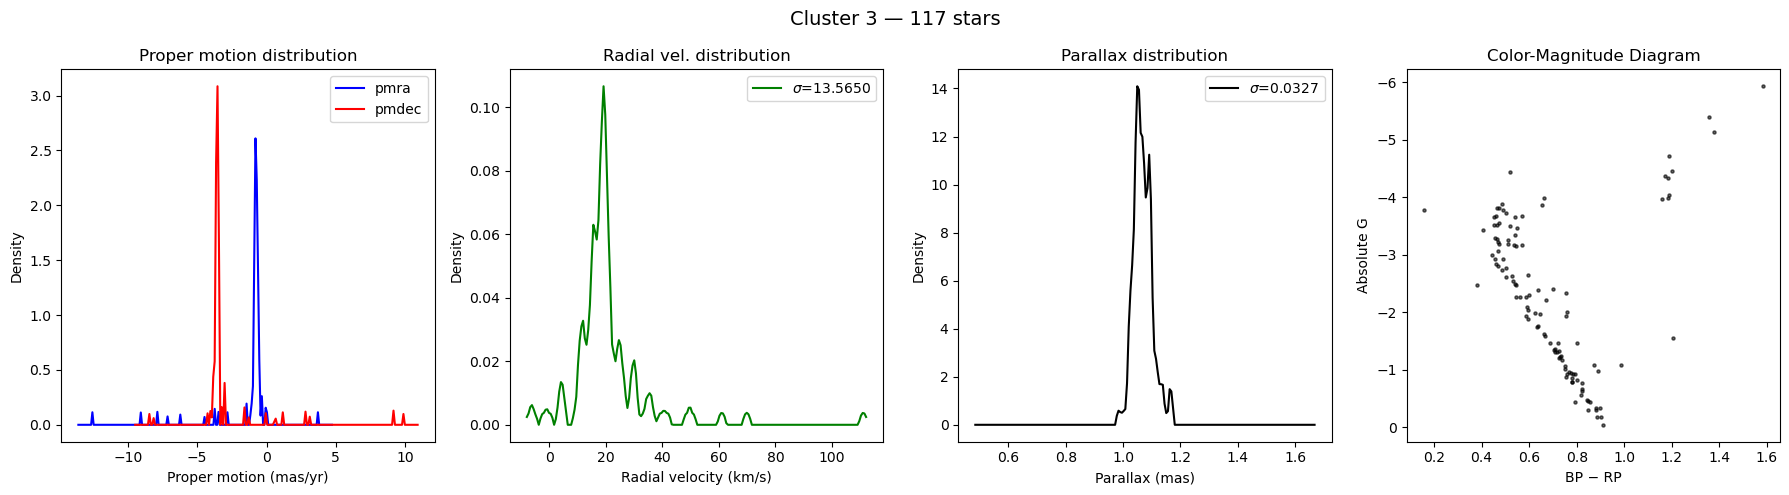

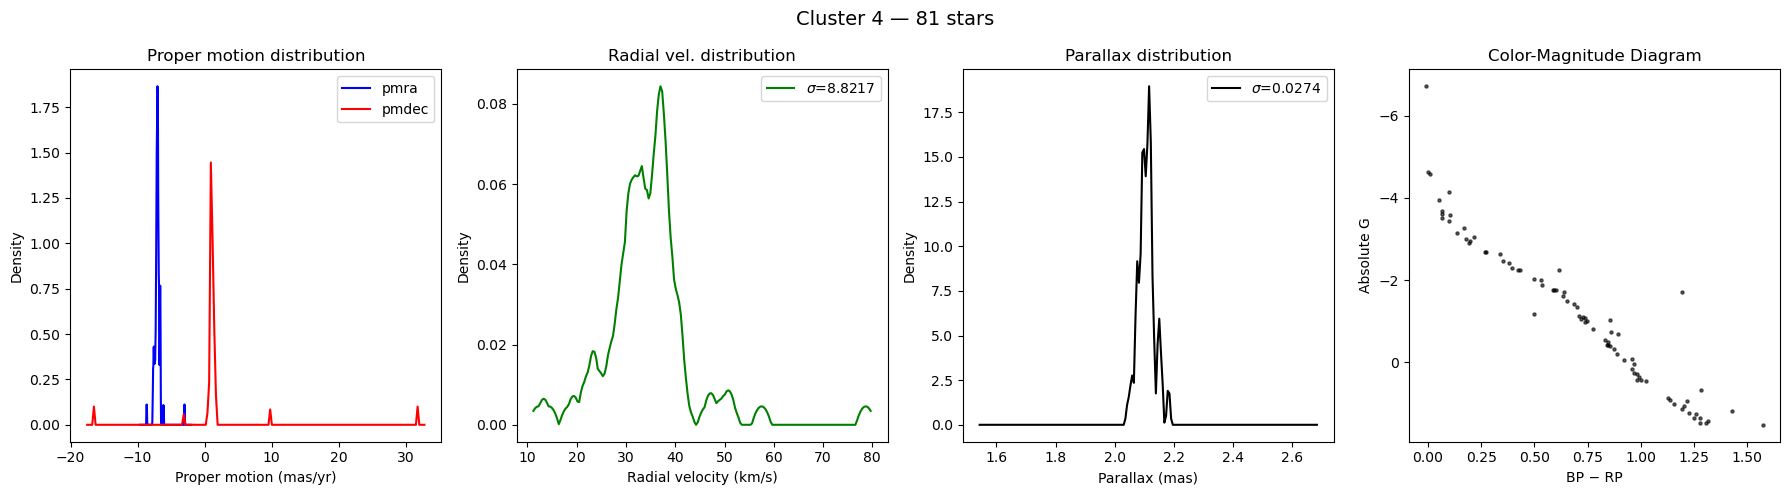

In [90]:
field_df.cluster = labels

for k in unique_labels: # loop over each unique cluster for plotting
    if k == -1: 
        continue  # skip noise

    cluster_df = field_df[field_df.cluster == k] # select points in cluster k
    
    fig, axs = plt.subplots(1, 4, figsize=(18, 5))
    fig.suptitle(f"Cluster {k+1} — {len(cluster_df)} stars", fontsize=14)

    # Motion histograms
    xgrid = np.linspace(cluster_df.pmra.min() - 1, cluster_df.pmra.max() + 1, 200) # 200 points to smoothly plot KDE over range of distribution values 
    axs[0].plot(xgrid, kde(cluster_df.pmra, xgrid), label="pmra", color="blue")
    xgrid = np.linspace(cluster_df.pmdec.min() - 1, cluster_df.pmdec.max() + 1, 200)
    axs[0].plot(xgrid, kde(cluster_df.pmdec, xgrid), label="pmdec", color="red")
    axs[0].set_xlabel("Proper motion (mas/yr)")
    axs[0].set_ylabel("Density")
    axs[0].legend()
    axs[0].set_title("Proper motion distribution")

    # Radial velocity histograms
    xgrid = np.linspace(cluster_df.radvel.min() - 1, cluster_df.radvel.max() + 1, 200) 
    axs[1].plot(xgrid, kde(cluster_df.radvel, xgrid), label=f"$\sigma$={np.std(cluster_df.radvel):.4f}", color="green")
    axs[1].set_xlabel("Radial velocity (km/s)")
    axs[1].set_ylabel("Density")
    axs[1].set_title("Radial vel. distribution")
    axs[1].legend()    

    # Parallax histogram
    xgrid = np.linspace(cluster_df.parallax.min() - 0.5, cluster_df.parallax.max() + 0.5, 200)    
    axs[2].plot(xgrid, kde(cluster_df.parallax, xgrid), label=f"$\sigma$={np.std(cluster_df.parallax):.4f}", color='k')
    axs[2].set_xlabel("Parallax (mas)")
    axs[2].set_ylabel("Density")
    axs[2].set_title("Parallax distribution")
    axs[2].legend()

    # CMD: color vs. absolute G
    bp_rp = cluster_df.bp - cluster_df.rp
    abs_g = cluster_df.g - 5 * np.log10(1000 / cluster_df.parallax)
    axs[3].scatter(bp_rp, abs_g, s=5, color='black', alpha=0.6)
    axs[3].invert_yaxis()
    axs[3].set_xlabel("BP − RP")
    axs[3].set_ylabel("Absolute G")
    axs[3].set_title("Color-Magnitude Diagram")



    plt.tight_layout()
    plt.show()

/var/folders/y3/_hj0h0sd6b1811vf6kl003g40000gn/T/ipykernel_70642/2096567555.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_df.cluster_tmp = labels
/var/folders/y3/_hj0h0sd6b1811vf6kl003g40000gn/T/ipykernel_70642/2096567555.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  field_df.cluster_tmp = labels
/var/folders/y3/_hj0h0sd6b1811vf6kl003g40000gn/T/ipykernel_70642/2096567555.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

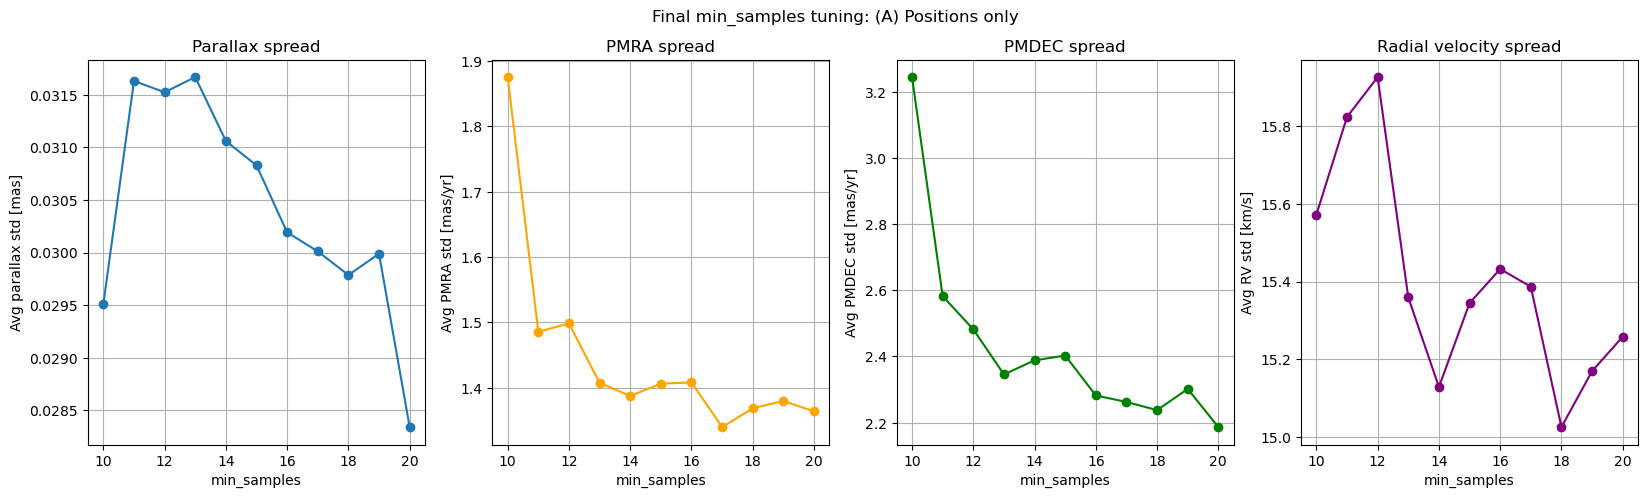

In [97]:
##### min_samples tuning by feature distribution spreads

# Build the feature matrix --- shape (n_samples, n_features)
X = np.vstack([field_df.ra,field_df.dec, field_df.parallax]).T

# Scale features
Xs = StandardScaler().fit_transform(X)

# Parameter ranges
eps_val = 0.0379
min_samples_values = np.linspace(10,20,10)

min_samples_values = np.arange(10, 21, 1)  # 10 to 20 inclusive

# Storage for results
results = []

for min_samples in min_samples_values:
    db = DBSCAN(eps=eps_val, min_samples=min_samples).fit(Xs)
    labels = db.labels_

    # Attach labels to a temporary DataFrame
    field_df.cluster_tmp = labels

    # Only use real clusters (ignore noise) ### used chatgpt here
    mask = labels != -1
    if np.sum(mask) < 5:
        continue

    # Compute physical spreads across all clusters
    parallax_spreads = []
    pmra_spreads = []
    pmdec_spreads = []
    radvel_spreads = []

    unique_labels = np.unique(labels)
    
    for k in unique_labels:
        if k == -1:
            continue  # skip noise
        cluster_df = field_df[field_df.cluster_tmp == k]
        parallax_spreads.append(np.std(cluster_df.parallax))
        pmra_spreads.append(np.std(cluster_df.pmra))
        pmdec_spreads.append(np.std(cluster_df.pmdec))
        radvel_spreads.append(np.std(cluster_df.radvel))

    # Average spread per clustering
    avg_parallax = np.mean(parallax_spreads)
    avg_pmra = np.mean(pmra_spreads)
    avg_pmdec = np.mean(pmdec_spreads)
    avg_radvel = np.mean(radvel_spreads)

    # Save results
    results.append((min_samples, avg_parallax, avg_pmra, avg_pmdec, avg_radvel))

# Convert results to numpy array for easy plotting
results = np.array(results)


# Plot
fig, axs = plt.subplots(1, 4, figsize=(20,5))#, sharex=True)
fig.suptitle("Final min_samples tuning: (A) Positions only ")

axs[0].plot(results[:,0], results[:,1], 'o-'); axs[0].set_xlabel('min_samples'); axs[0].set_ylabel('Avg parallax std [mas]'); axs[0].set_title('Parallax spread'); axs[0].grid(True)

axs[1].plot(results[:,0], results[:,2], 'o-', color='orange'); axs[1].set_xlabel('min_samples'); axs[1].set_ylabel('Avg PMRA std [mas/yr]'); axs[1].set_title('PMRA spread'); axs[1].grid(True)

axs[2].plot(results[:,0], results[:,3], 'o-', color='green'); axs[2].set_xlabel('min_samples'); axs[2].set_ylabel('Avg PMDEC std [mas/yr]'); axs[2].set_title('PMDEC spread'); axs[2].grid(True)

axs[3].plot(results[:,0], results[:,4], 'o-', color='purple'); axs[3].set_xlabel('min_samples'); axs[3].set_ylabel('Avg RV std [km/s]'); axs[3].set_title('Radial velocity spread'); axs[3].grid(True)

plt.show()

array([6.1442324 , 6.18462521, 6.38772276, 6.42874131, 6.58700643,
       6.8368092 , 7.03052595, 7.20378037, 7.33224329, 7.57613226,
       7.76732279])

### Clustering including kinematics

In [39]:
def sigma_clipper(df, N):
    """
    Clips each column in a DataFrame to be within N standard deviations
    of its column mean.
    
    Parameters:
        df (pd.DataFrame): input DataFrame
        N (float): number of standard deviations for clipping
        
    Returns:
        pd.DataFrame: clipped DataFrame with only rows where all values
                      are within N sigma in their respective columns
    """
    means = df.mean()
    stds = df.std()

    mask = ((df < (means + N * stds)) & (df > (means - N * stds))).all(axis=1)
    return df[mask]



In [91]:
df_clp = sigma_clipper(field_df2[['pmra', 'pmdec', 'parallax', 'radvel']], 5)

# Preserve RA/Dec
ra = field_df2.loc[df_clp.index, 'ra'].values
dec = field_df2.loc[df_clp.index, 'dec'].values
df_clp['ra'] = ra; df_clp['dec'] = dec

# Build the feature matrix --- shape (n_samples, n_features)

X = np.vstack([
    df_clp.ra,
    df_clp.dec,
    df_clp.parallax,
    df_clp.pmra,
    df_clp.pmdec,
    df_clp.radvel
]).T


# Scale features
# Xs = RobustScaler().fit_transform(X)
Xs = StandardScaler().fit_transform(X)

In [115]:
# Parameter ranges
eps_values = np.linspace(0.04, 0.1, 15)
min_samples_values = [5, 10, 15, 20, 25]

# Track best configuration
best_score_init = -1
best_params = None # initialize best_params
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        # calculate DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(Xs)
        labels = db.labels_

        # count (real) clusters
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # Only evaluate silhouette if 2 or more clusters exist
        if n_clusters >= 2:
            score = silhouette_score(Xs, labels)
            results.append((eps, min_samples, score))
            print(f"eps={eps:.4f}, min_samples={min_samples} : silhouette={score:.4f}")

            if score > best_score_init:
                best_score_init = score # reassign best score to current score if better than previous
                best_params = (eps, min_samples)

best_score = best_score_init
print("\nBest parameters:")
print(f"eps={best_params[0]:.4f}, min_samples={best_params[1]} → silhouette={best_score:.4f}")

eps=0.0443, min_samples=5 : silhouette=-0.3223
eps=0.0486, min_samples=5 : silhouette=-0.3194
eps=0.0529, min_samples=5 : silhouette=-0.3551
eps=0.0571, min_samples=5 : silhouette=-0.3557
eps=0.0571, min_samples=10 : silhouette=-0.3143
eps=0.0614, min_samples=5 : silhouette=-0.3533
eps=0.0614, min_samples=10 : silhouette=-0.3098
eps=0.0657, min_samples=5 : silhouette=-0.4177
eps=0.0657, min_samples=10 : silhouette=-0.3087
eps=0.0657, min_samples=15 : silhouette=-0.3148
eps=0.0700, min_samples=5 : silhouette=-0.4208
eps=0.0700, min_samples=10 : silhouette=-0.3106
eps=0.0700, min_samples=15 : silhouette=-0.3131
eps=0.0700, min_samples=20 : silhouette=-0.3113
eps=0.0743, min_samples=5 : silhouette=-0.4210
eps=0.0743, min_samples=10 : silhouette=-0.3495
eps=0.0743, min_samples=15 : silhouette=-0.3077
eps=0.0743, min_samples=20 : silhouette=-0.3105
eps=0.0786, min_samples=5 : silhouette=-0.4253
eps=0.0786, min_samples=10 : silhouette=-0.3427
eps=0.0786, min_samples=15 : silhouette=-0.3055
e

(0.1, 25)


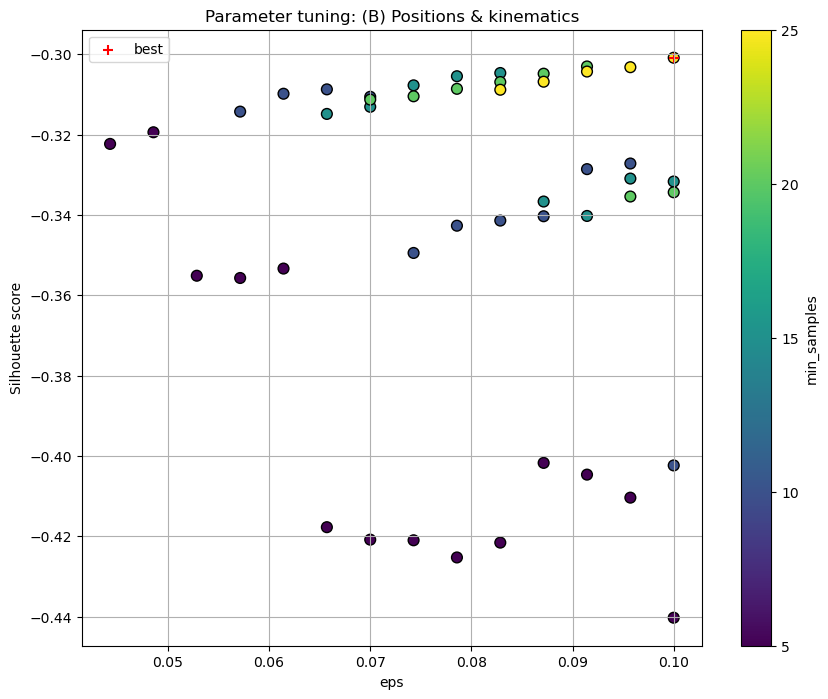

In [116]:
# Visualize tuning results
tuning_res = pd.DataFrame(results,columns=["eps", "min_samples", "silhouette"])

plt.figure(figsize=(10,8))
scatter = plt.scatter(
    tuning_res.eps,
    tuning_res.silhouette,
    c=tuning_res.min_samples,
    cmap='viridis',
    s=60,
    edgecolor='k'
)

plt.scatter(best_params[0],best_score, c='r', marker='+', s=60, label='best')
cbar = plt.colorbar(scatter)
ticks_to_show = np.sort(np.unique(tuning_res.min_samples))
cbar.set_ticks(ticks_to_show)
cbar.set_ticklabels([str(v) for v in ticks_to_show])
cbar.set_label('min_samples')
plt.grid(True)

plt.title('Parameter tuning: (B) Positions & kinematics'); plt.legend(); plt.xlabel('eps'); plt.ylabel('Silhouette score')

print(best_params)

Estimated number of clusters: 4
Estimated number of noise points: 41864
Total number of points: 42211


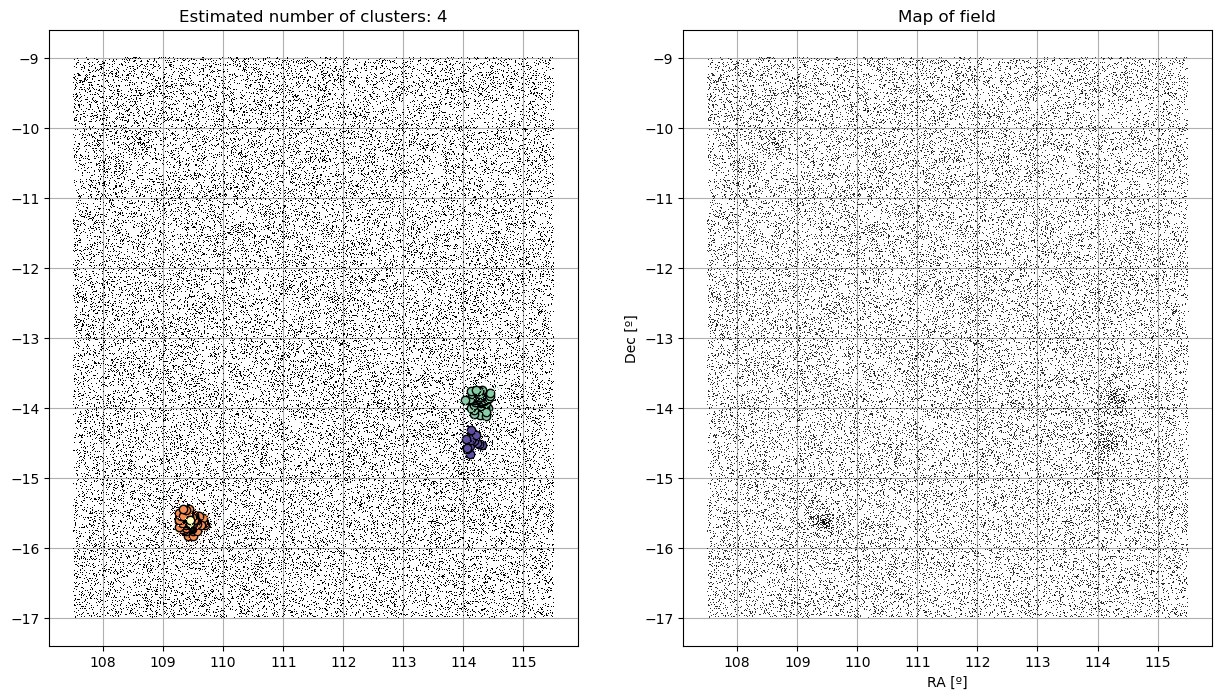

In [121]:
# Dimensionality reduction
#X_pca = PCA(n_components=2).fit_transform(Xs)

start = time.time()

# Compute DBSCAN
#################################################
#################################################
db = DBSCAN(eps=0.1, min_samples=16).fit(Xs)
#db = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit(Xs)
#################################################
#################################################

#print("Done in", time.time() - start, "seconds")
labels = db.labels_

# Bool mask that is True for values that belong to a cluster (i.e. not outliers)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print('Total number of points: %d' % len(Xs))
#print(f"Silhouette score: {silhouette_score(Xs, labels):.4f}")


# Choose the number of colors based on the number of clusters (i.e., the number of unique cluster labels)
# Black is removed and is used for noise instead.
unique_labels = np.unique(labels)
colors = [plt.cm.Spectral(i) for i in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
# Now plot each cluster, one by one
for k, col in zip(unique_labels, colors):
    if k == -1:
        # sets the color for the -1 label to black
        # this is just the way the matplotlib colormap values are set up
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k) # bool mask, True where the label is equal to k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    # Plot the outliers as a black 'x'
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], ',', markerfacecolor=tuple(col),markeredgecolor='k', markersize=0.5)

plt.grid(True)
plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.subplot(1,2,2)
plt.plot(df_clp.ra, df_clp.dec, 'k,', alpha=0.8)
plt.xlabel('RA [º]'); plt.ylabel('Dec [º]'); plt.title('Map of field')
plt.grid(True)
plt.show()

#print(f"sil score = {silhouette_score(Xs, labels):.4f}")

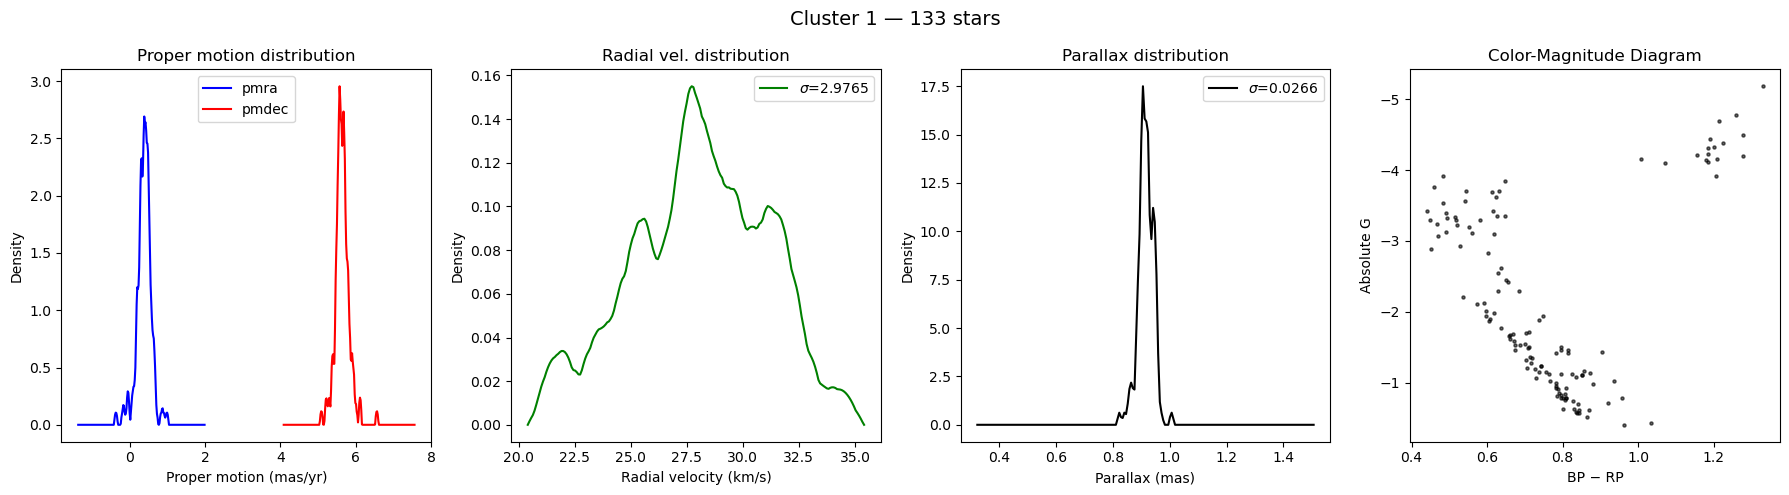

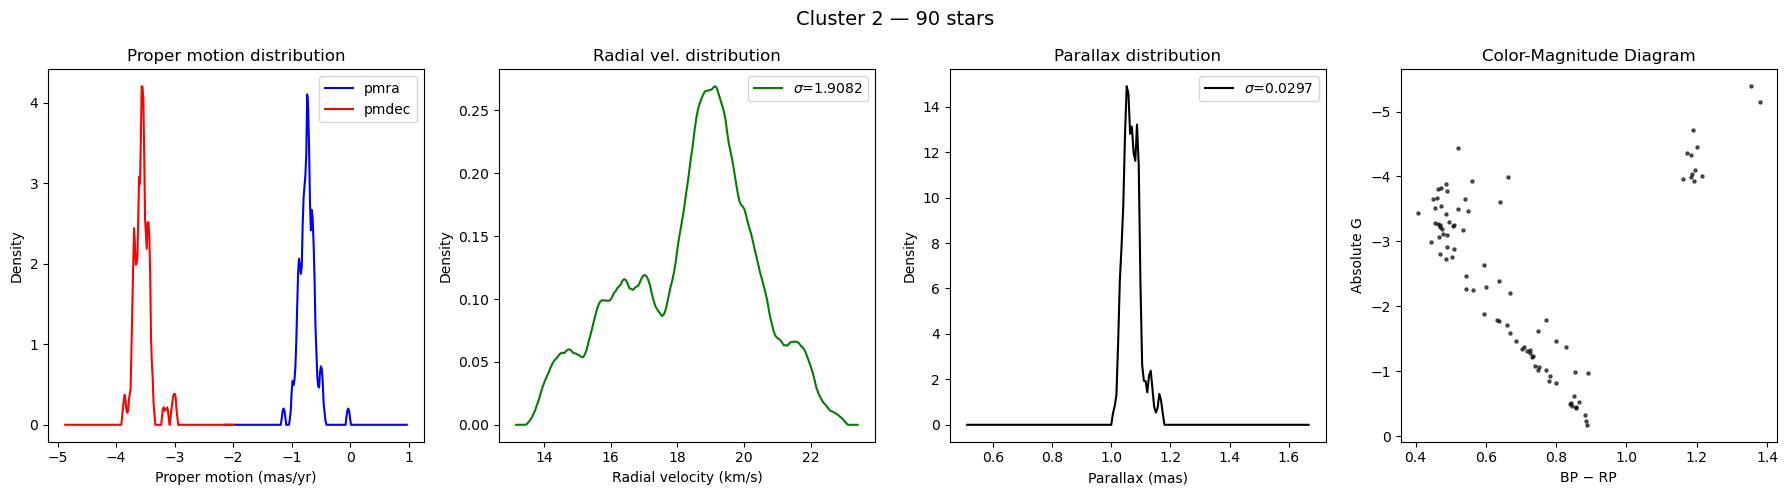

In [118]:
df_clp['cluster'] = labels 

bp = field_df2.loc[df_clp.index, 'bp'].values
rp = field_df2.loc[df_clp.index, 'rp'].values
g = field_df2.loc[df_clp.index, 'g'].values
df_clp['bp'] = bp; df_clp['rp'] = rp; df_clp['g'] = g

for k in unique_labels: # loop over each unique cluster for plotting
    if k == -1: 
        continue  # skip noise

    cluster_df = df_clp[df_clp.cluster == k] # select points in cluster k
    
    fig, axs = plt.subplots(1, 4, figsize=(18, 5))
    fig.suptitle(f"Cluster {k+1} — {len(cluster_df)} stars", fontsize=14)

    # Motion histograms
    xgrid = np.linspace(cluster_df.pmra.min() - 1, cluster_df.pmra.max() + 1, 200) # 200 points to smoothly plot KDE over range of distribution values 
    axs[0].plot(xgrid, kde(cluster_df.pmra, xgrid), label="pmra", color="blue")
    xgrid = np.linspace(cluster_df.pmdec.min() - 1, cluster_df.pmdec.max() + 1, 200)
    axs[0].plot(xgrid, kde(cluster_df.pmdec, xgrid), label="pmdec", color="red")
    axs[0].set_xlabel("Proper motion (mas/yr)")
    axs[0].set_ylabel("Density")
    axs[0].legend()
    axs[0].set_title("Proper motion distribution")

    # Radial velocity histograms
    xgrid = np.linspace(cluster_df.radvel.min() - 1, cluster_df.radvel.max() + 1, 200) 
    axs[1].plot(xgrid, kde(cluster_df.radvel, xgrid), label=f"$\sigma$={np.std(cluster_df.radvel):.4f}", color="green")
    axs[1].set_xlabel("Radial velocity (km/s)")
    axs[1].set_ylabel("Density")
    axs[1].set_title("Radial vel. distribution")
    axs[1].legend()    

    # Parallax histogram
    xgrid = np.linspace(cluster_df.parallax.min() - 0.5, cluster_df.parallax.max() + 0.5, 200)    
    axs[2].plot(xgrid, kde(cluster_df.parallax, xgrid), label=f"$\sigma$={np.std(cluster_df.parallax):.4f}", color='k')
    axs[2].set_xlabel("Parallax (mas)")
    axs[2].set_ylabel("Density")
    axs[2].set_title("Parallax distribution")
    axs[2].legend()

    # CMD: color vs. absolute G
    bp_rp = cluster_df.bp - cluster_df.rp
    abs_g = cluster_df.g - 5 * np.log10(1000 / cluster_df.parallax)
    axs[3].scatter(bp_rp, abs_g, s=5, color='black', alpha=0.6)
    axs[3].invert_yaxis()
    axs[3].set_xlabel("BP − RP")
    axs[3].set_ylabel("Absolute G")
    axs[3].set_title("Color-Magnitude Diagram")



    plt.tight_layout()
    plt.show()

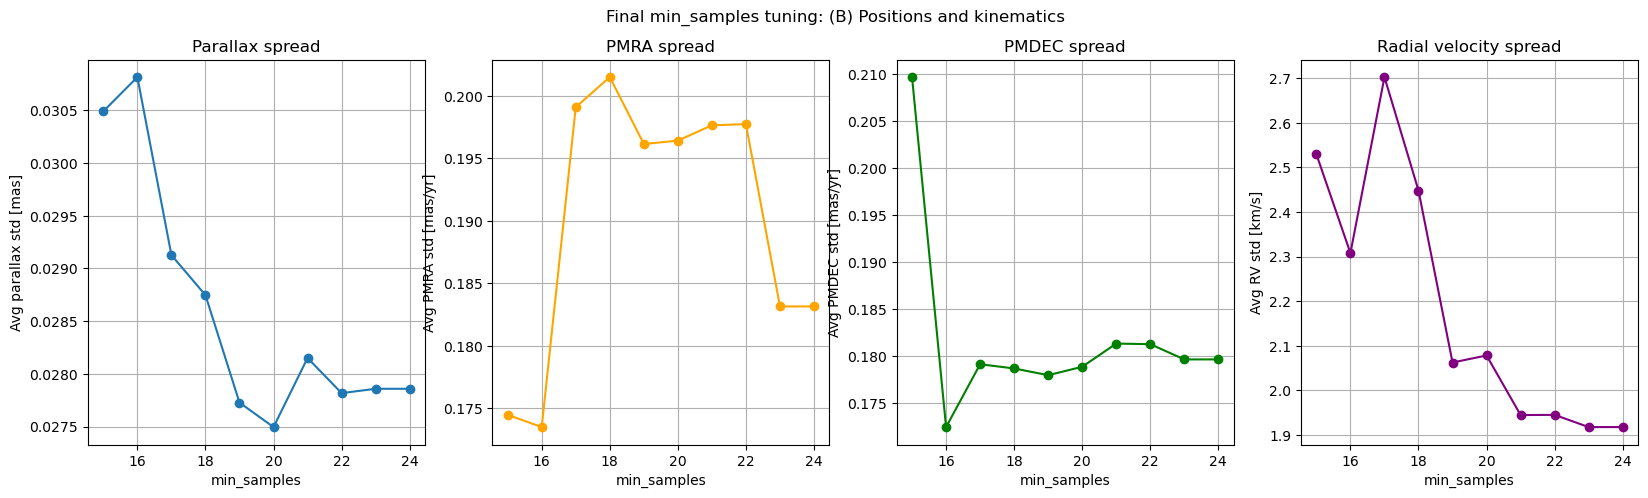

In [120]:
# ##### min_samples tuning by feature distribution spreads

# Build the feature matrix --- shape (n_samples, n_features)
X = np.vstack([
    df_clp.ra,
    df_clp.dec,
    df_clp.parallax,
    df_clp.pmra,
    df_clp.pmdec,
    df_clp.radvel
]).T


# Scale features
# Xs = RobustScaler().fit_transform(X)
Xs = StandardScaler().fit_transform(X)

# Parameter ranges
eps_val = 0.1

min_samples_values = np.arange(15, 25, 1)  # 2 to 12 inclusive

# Storage for results
results = []

for min_samples in min_samples_values:
    db = DBSCAN(eps=eps_val, min_samples=min_samples).fit(Xs)
    labels = db.labels_

    # Attach labels to a temporary DataFrame
    df_clp.cluster_tmp = labels

    # Only use real clusters (ignore noise) ### used chatgpt here
    mask = labels != -1
    if np.sum(mask) < 5:
        continue

    # Compute physical spreads across all clusters
    parallax_spreads = []
    pmra_spreads = []
    pmdec_spreads = []
    radvel_spreads = []

    unique_labels = np.unique(labels)
    
    for k in unique_labels:
        if k == -1:
            continue  # skip noise
        cluster_df = df_clp[df_clp.cluster_tmp == k]
        parallax_spreads.append(np.std(cluster_df.parallax))
        pmra_spreads.append(np.std(cluster_df.pmra))
        pmdec_spreads.append(np.std(cluster_df.pmdec))
        radvel_spreads.append(np.std(cluster_df.radvel))

    # Average spread per clustering
    avg_parallax = np.mean(parallax_spreads)
    avg_pmra = np.mean(pmra_spreads)
    avg_pmdec = np.mean(pmdec_spreads)
    avg_radvel = np.mean(radvel_spreads)

    # Save results
    results.append((min_samples, avg_parallax, avg_pmra, avg_pmdec, avg_radvel))

# Convert results to numpy array for easy plotting
results = np.array(results)


# Plot
fig, axs = plt.subplots(1, 4, figsize=(20,5))#, sharex=True)
fig.suptitle("Final min_samples tuning: (B) Positions and kinematics ")

axs[0].plot(results[:,0], results[:,1], 'o-'); axs[0].set_xlabel('min_samples'); axs[0].set_ylabel('Avg parallax std [mas]'); axs[0].set_title('Parallax spread'); axs[0].grid(True)

axs[1].plot(results[:,0], results[:,2], 'o-', color='orange'); axs[1].set_xlabel('min_samples'); axs[1].set_ylabel('Avg PMRA std [mas/yr]'); axs[1].set_title('PMRA spread'); axs[1].grid(True)

axs[2].plot(results[:,0], results[:,3], 'o-', color='green'); axs[2].set_xlabel('min_samples'); axs[2].set_ylabel('Avg PMDEC std [mas/yr]'); axs[2].set_title('PMDEC spread'); axs[2].grid(True)

axs[3].plot(results[:,0], results[:,4], 'o-', color='purple'); axs[3].set_xlabel('min_samples'); axs[3].set_ylabel('Avg RV std [km/s]'); axs[3].set_title('Radial velocity spread'); axs[3].grid(True)

plt.show()

### For flash talk

In [20]:
ngc2168_mask = (field_df.ra > 91.4 ) & (field_df.ra < 92.9) & (field_df.dec > 23.9) & (field_df.dec < 24.9)

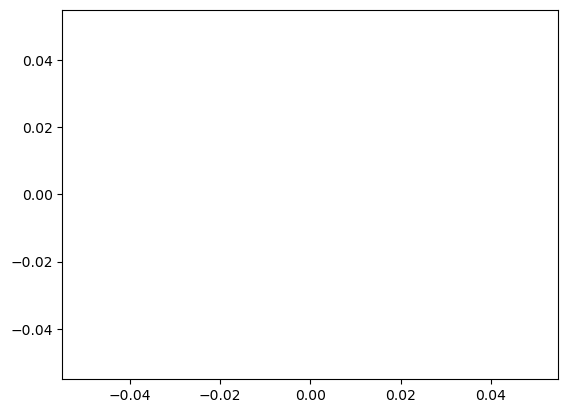

In [21]:
plt.plot(field_df[ngc2168_mask].ra,field_df[ngc2168_mask].dec, 'ko', alpha=0.1) 

/Users/michaelstruk/miniconda3/envs/astro-416/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


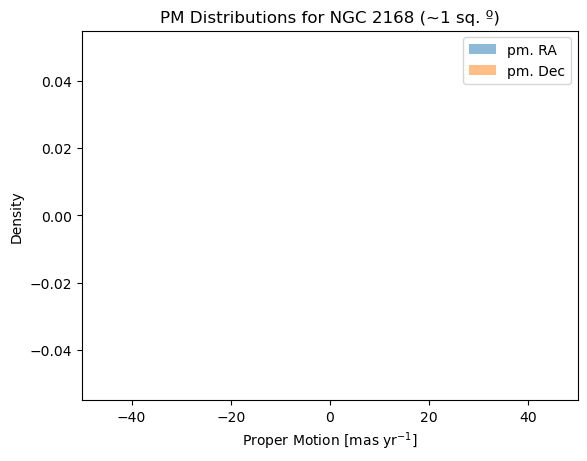

(3.5, 0.0)

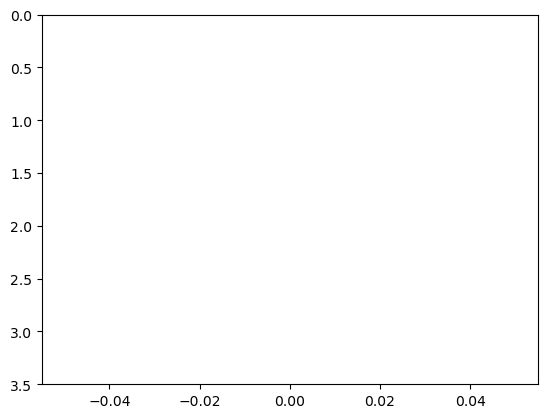

In [22]:
plt.hist(field_df[ngc2168_mask].pmra, bins=75, alpha=0.5, density = True, label='pm. RA')
plt.hist(field_df[ngc2168_mask].pmdec, bins=75, alpha=0.5, density = True, label='pm. Dec')
plt.title('PM Distributions for NGC 2168 (~1 sq. º)'); plt.xlabel('Proper Motion [mas yr$^{-1}$]'); plt.ylabel('Density')
plt.xlim(-50, 50)
plt.legend()
plt.show();

plt.plot(field_df[ngc2168_mask].g, field_df[ngc2168_mask].bp-field_df[ngc2168_mask].rp, 'k,')
plt.ylim(3.5,0)

In [23]:
len(field_df[ngc2168_mask].g)

0